In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from random import random
from glob import glob

## Data exploration

In [7]:
df = pd.read_csv("./datasets/chinesemnist/chinese_mnist.csv")
df.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [17]:
paths = glob("./datasets/chinesemnist/data/data/*.jpg")
# Shuffle paths
paths = np.random.permutation(paths)
# Split into train, validation, and test with 80%, 10%, 10% split
train_paths = paths[:int(len(paths)*0.8)]
val_paths = paths[int(len(paths)*0.8):int(len(paths)*0.9)]
test_paths = paths[int(len(paths)*0.9):]
print(len(train_paths), len(val_paths), len(test_paths))

12000 1500 1500


In [24]:
def load_images(paths):
    images = []
    ids = []
    for path in paths:
        char_idx = int(path.split("_")[-1][:-4])
        images.append(plt.imread(path))
        ids.append(char_idx)
    return np.array(images), ids

train_images, train_ids = load_images(train_paths)
val_images, val_ids = load_images(val_paths)
test_images, test_ids = load_images(test_paths)
print(train_images.shape, val_images.shape, test_images.shape)

(12000, 64, 64) (1500, 64, 64) (1500, 64, 64)


Now we have a dataset 
$$
(X_{i...N_{train/test/val}}, Y_{i...N_{train/test/val}})
$$ 
Where $X_i \in \mathbb{R^{64 \times 64}}$ is an image of dimensions 64 by 64 pixels. and $Y_i \in \mathbb{Z}$ represents the character index 

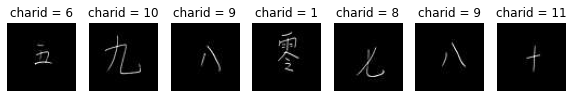

In [44]:
nsamples = 7
for i in range(nsamples):
    plt.subplot(1, nsamples, i+1).imshow(train_images[i], cmap="gray")
    plt.subplot(1, nsamples, i+1).set_title(f"charid = {train_ids[i]}")
    plt.axis("off")
plt.gcf().set_size_inches(10, 10)
plt.show()